## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [3]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [131]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

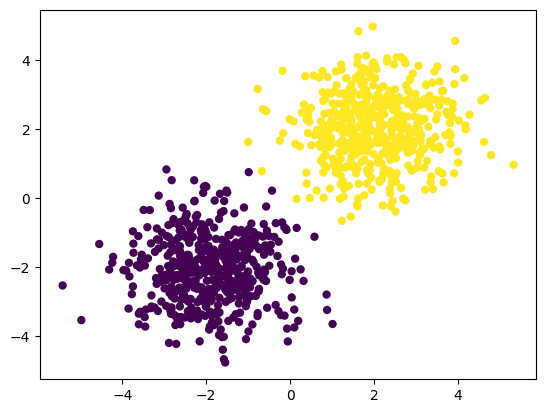

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ELU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 2
LogSoftMax

Linear 2 -> 4
ELU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [38]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 800
batch_size = 5000

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

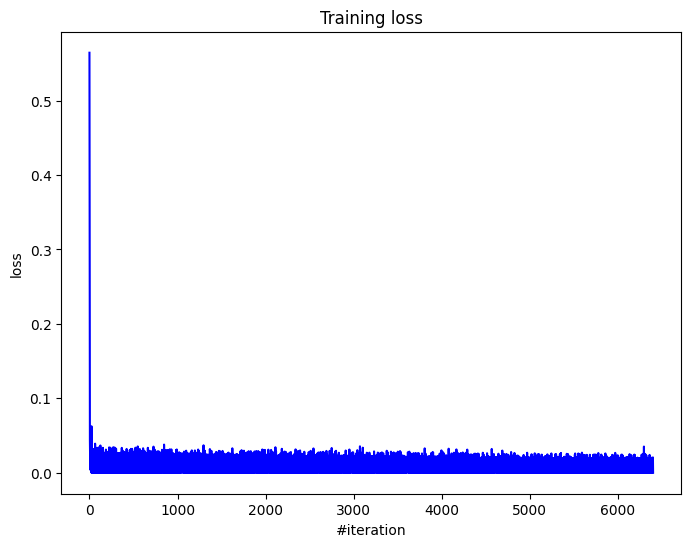

Current loss: 0.000026


In [34]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [37]:
import mnist
X_train, y_train_unenc, X_val, y_val_unenc, X_test, y_test = mnist.load_dataset()
X_train = X_train.reshape(-1, 784)
X_val = X_val.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
print(len(X_train))
print(len(X_val))
print(len(X_test))

50000
10000
10000


Digits example:


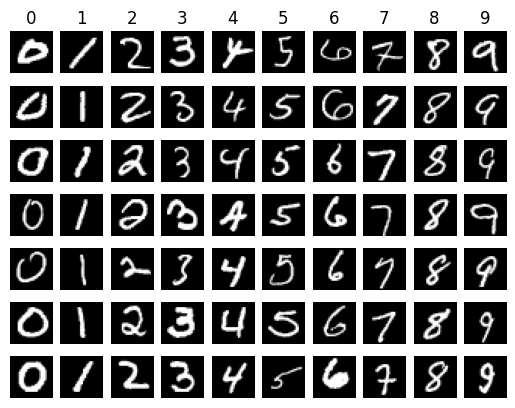

In [27]:
print("Digits example:")
classes = list(np.arange(10))
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train_unenc == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow((256 * X_train[idx]).reshape((28, 28)).astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

One-hot encode the labels first.

In [94]:
from sklearn.preprocessing import OneHotEncoder
oh_encoder = OneHotEncoder(sparse=False)
y_train = oh_encoder.fit_transform(y_train_unenc.reshape(-1, 1))
y_val = oh_encoder.fit_transform(y_val_unenc.reshape(-1, 1))

C:\Users\JulesIMF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\JulesIMF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [146]:
# Выделим обучение в отдельную функцию
from time import time

def validate_network(net):
    ans = net.forward(X_val)    
    return np.sum(np.argmax(ans, axis=1) == y_val_unenc) / len(X_val)

def train_network(trained_net,
                  name: str,
                  n_epoch = 100,
                  batch_size = 1000,
                  criterion = ClassNLLCriterion(),
                  optimizer = sgd_momentum,
                  optimizer_config = {'learning_rate' : 5e-2, 'momentum': 0.9},
                  optimizer_state = {}):

    net = trained_net
    net.train()
    loss_history = []

    start = time()
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            optimizer(net.getParameters(),
                        net.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)      
            
            loss_history.append(loss)
        
        print(f'#{i + 1}/{n_epoch} epoch loss: {round(loss, 7)}', end='\r')
    
    exec = time() - start
    net.evaluate()
    return net, exec, loss_history

In [90]:
net_relu = Sequential()
net_relu.add(Linear(784, 256))
net_relu.add(ReLU())
net_relu.add(Linear(256, 100))
net_relu.add(ReLU())
net_relu.add(Linear(100, 10))
net_relu.add(LogSoftMax())

net_relu, exec_relu, loss_relu = train_network(net_relu, "net_relu")
print(f"\nFinal accuracy: {validate_network(net_relu)}")
print(f"\nTime elapsed: {exec_relu}")

#100/100 epoch loss: 0.0015112
Final accuracy: 0.982

Time elapsed: 82.09498596191406


In [91]:
net_elu = Sequential()
net_elu.add(Linear(784, 256))
net_elu.add(ELU())
net_elu.add(Linear(256, 100))
net_elu.add(ELU())
net_elu.add(Linear(100, 10))
net_elu.add(LogSoftMax())

net_elu, exec_elu, loss_elu = train_network(net_elu, "net_elu")
print(f"\nFinal accuracy: {validate_network(net_elu)}")
print(f"\nTime elapsed: {exec_elu}")


#100/100 epoch loss: 0.0031516
Final accuracy: 0.9783

Time elapsed: 110.26100087165833


In [92]:
net_lrelu = Sequential()
net_lrelu.add(Linear(784, 256))
net_lrelu.add(LeakyReLU())
net_lrelu.add(Linear(256, 100))
net_lrelu.add(LeakyReLU())
net_lrelu.add(Linear(100, 10))
net_lrelu.add(LogSoftMax())

net_lrelu, exec_lrelu, loss_lrelu = train_network(net_lrelu, "net_lrelu")
print(f"\nFinal accuracy: {validate_network(net_lrelu)}")
print(f"\nTime elapsed: {exec_lrelu}")


#100/100 epoch loss: 0.0012234
Final accuracy: 0.9809

Time elapsed: 77.09099984169006


In [93]:
net_sp = Sequential()
net_sp.add(Linear(784, 256))
net_sp.add(SoftPlus())
net_sp.add(Linear(256, 100))
net_sp.add(SoftPlus())
net_sp.add(Linear(100, 10))
net_sp.add(LogSoftMax())

net_sp, exec_sp, loss_sp = train_network(net_sp, "net_sp")
print(f"\nFinal accuracy: {validate_network(net_sp)}")
print(f"\nTime elapsed: {exec_sp}")


#100/100 epoch loss: 0.0162606
Final accuracy: 0.9757

Time elapsed: 106.27951669692993


__Комментарий:__ можно увидеть, что ReLU и LReLU выдают лучшие результаты и обучаются заметно быстрее (что ожидаемо), поэтому в этой задаче их использование предпочтительнее. Тем не менее, попробуем теперь вставить нормировку и посмотрим, как себя поведут все 4 функции.

In [136]:
net_relu_batch = Sequential()
net_relu_batch.add(Linear(784, 256))
net_relu_batch.add(BatchNormalization(alpha=0.85))
net_relu_batch.add(ChannelwiseScaling(n_out=256))
net_relu_batch.add(ReLU())
net_relu_batch.add(Linear(256, 100))
net_relu_batch.add(BatchNormalization(alpha=0.85))
net_relu_batch.add(ChannelwiseScaling(n_out=100))
net_relu_batch.add(ReLU())
net_relu_batch.add(Linear(100, 10))
net_relu_batch.add(LogSoftMax())

net_relu_batch, exec_relu_batch, loss_relu_batch = train_network(net_relu_batch, "net_relu_batch")
print(f"\nFinal accuracy: {validate_network(net_relu_batch)}")
print(f"\nTime elapsed: {exec_relu_batch}")


#100/100 epoch loss: 0.0002072
Final accuracy: 0.9802

Time elapsed: 122.07674479484558


In [137]:
net_elu_batch = Sequential()
net_elu_batch.add(Linear(784, 256))
net_elu_batch.add(BatchNormalization(alpha=0.85))
net_elu_batch.add(ChannelwiseScaling(n_out=256))
net_elu_batch.add(ELU())
net_elu_batch.add(Linear(256, 100))
net_elu_batch.add(BatchNormalization(alpha=0.85))
net_elu_batch.add(ChannelwiseScaling(n_out=100))
net_elu_batch.add(ELU())
net_elu_batch.add(Linear(100, 10))
net_elu_batch.add(LogSoftMax())

net_elu_batch, exec_elu_batch, loss_elu_batch = train_network(net_elu_batch, "net_elu_batch")
print(f"\nFinal accuracy: {validate_network(net_elu_batch)}")
print(f"\nTime elapsed: {exec_elu_batch}")


#100/100 epoch loss: 0.0009403
Final accuracy: 0.9762

Time elapsed: 175.26955652236938


In [138]:
net_lrelu_batch = Sequential()
net_lrelu_batch.add(Linear(784, 256))
net_lrelu_batch.add(BatchNormalization(alpha=0.85))
net_lrelu_batch.add(ChannelwiseScaling(n_out=256))
net_lrelu_batch.add(LeakyReLU())
net_lrelu_batch.add(Linear(256, 100))
net_lrelu_batch.add(BatchNormalization(alpha=0.85))
net_lrelu_batch.add(ChannelwiseScaling(n_out=100))
net_lrelu_batch.add(LeakyReLU())
net_lrelu_batch.add(Linear(100, 10))
net_lrelu_batch.add(LogSoftMax())

net_lrelu_batch, exec_lrelu_batch, loss_lrelu_batch = train_network(net_lrelu_batch, "net_lrelu_batch")
print(f"\nFinal accuracy: {validate_network(net_lrelu_batch)}")
print(f"\nTime elapsed: {exec_lrelu_batch}")


#100/100 epoch loss: 0.0001639
Final accuracy: 0.9796

Time elapsed: 148.72912740707397


In [139]:
net_sp_batch = Sequential()
net_sp_batch.add(Linear(784, 256))
net_sp_batch.add(BatchNormalization(alpha=0.85))
net_sp_batch.add(ChannelwiseScaling(n_out=256))
net_sp_batch.add(SoftPlus())
net_sp_batch.add(Linear(256, 100))
net_sp_batch.add(BatchNormalization(alpha=0.85))
net_sp_batch.add(ChannelwiseScaling(n_out=100))
net_sp_batch.add(SoftPlus())
net_sp_batch.add(Linear(100, 10))
net_sp_batch.add(LogSoftMax())

net_sp_batch, exec_sp_batch, loss_sp_batch = train_network(net_sp_batch, "net_sp_batch")
print(f"\nFinal accuracy: {validate_network(net_sp_batch)}")
print(f"\nTime elapsed: {exec_sp_batch}")


#100/100 epoch loss: 0.0009643
Final accuracy: 0.9757

Time elapsed: 159.44002532958984


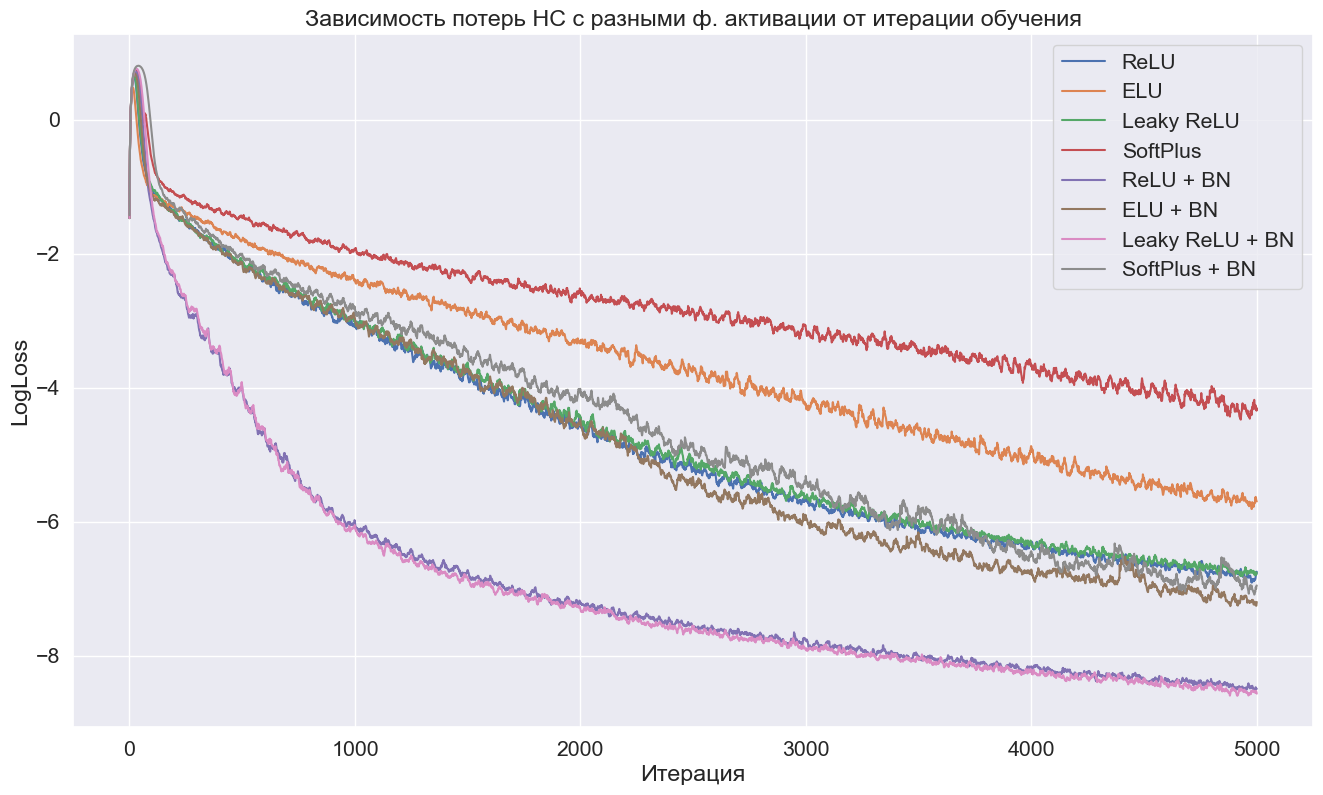

In [145]:
import seaborn as sns

# Эта функция сглаживает колебания и берет логарифм от полученного результата
def preproc(arr, alpha = 0.9):
    processed = []
    old = 0.0
    for t in arr:
        new = t * (1.0 - alpha) + old * alpha
        processed.append(new)
        old = new
    
    return np.log(processed)

sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(16,9))
plt.title("Зависимость потерь НС с разными ф. активации от итерации обучения")
plt.ylabel("LogLoss")
plt.xlabel("Итерация")
plt.plot(preproc(loss_relu), label='ReLU')
plt.plot(preproc(loss_elu), label='ELU')
plt.plot(preproc(loss_lrelu), label='Leaky ReLU')
plt.plot(preproc(loss_sp), label='SoftPlus')
plt.plot(preproc(loss_relu_batch), label='ReLU + BN')
plt.plot(preproc(loss_elu_batch), label='ELU + BN')
plt.plot(preproc(loss_lrelu_batch), label='Leaky ReLU + BN')
plt.plot(preproc(loss_sp_batch), label='SoftPlus + BN')
plt.legend()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

__Комментарий:__ для моей модели LeakyReLU и ReLU подходят лучше всего независимо от наличия нормировки и идут очень близко. ELU ведет себя несколько лучше SoftPlus, но значительно уступает ReLU / LReLU. При этом нормировка значительно ускоряет сходимость всех моделей, поэтому, несмотря на то, что время обучения вырастает примерно в два раза, использование такого слоя целесообразно.

Теперь посмотрим на то, как ведут себя разные оптимизаторы. Выберем в качестве функции ReLU.

In [163]:
net_relu_opt = Sequential()
net_relu_opt.add(Linear(784, 256))
net_relu_opt.add(BatchNormalization(alpha=0.85))
net_relu_opt.add(ChannelwiseScaling(n_out=256))
net_relu_opt.add(ReLU())
net_relu_opt.add(Linear(256, 100))
net_relu_opt.add(BatchNormalization(alpha=0.85))
net_relu_opt.add(ChannelwiseScaling(n_out=100))
net_relu_opt.add(ReLU())
net_relu_opt.add(Linear(100, 10))
net_relu_opt.add(LogSoftMax())

In [151]:
net_relu_sgd, exec_relu_sgd, loss_relu_sgd = train_network(net_relu_opt, "net_relu_sgd")
print(f"\nFinal accuracy: {validate_network(net_relu_sgd)}")
print(f"\nTime elapsed: {exec_relu_sgd}")

#100/100 epoch loss: 0.0002252
Final accuracy: 0.9793

Time elapsed: 134.87138891220093


In [152]:
optimizer_config_adam = {'learning_rate': 1e-3, 'beta1': 0.85, 'beta2': 0.85, 'epsilon': 1e-6}
optimizer_state_adam = {}

net_relu_adam, exec_relu_adam, loss_relu_adam = train_network(net_relu_opt, "net_relu_adam", optimizer=adam_optimizer,
optimizer_config=optimizer_config_adam, optimizer_state=optimizer_state_adam)
print(f"\nFinal accuracy: {validate_network(net_relu_adam)}")
print(f"\nTime elapsed: {exec_relu_adam}")


#100/100 epoch loss: 0.0001151
Final accuracy: 0.982

Time elapsed: 144.8511197566986


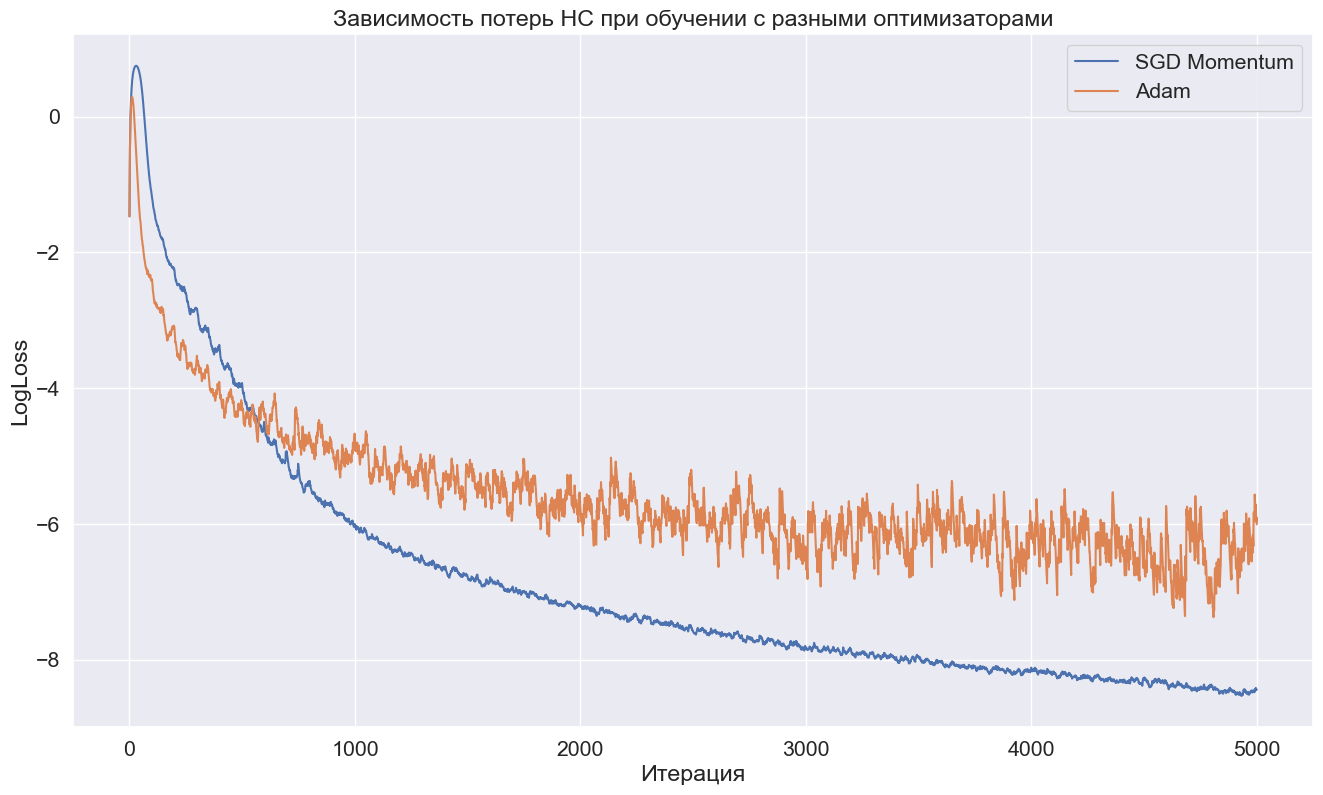

In [153]:
plt.figure(figsize=(16, 9))
plt.title("Зависимость потерь НС при обучении с разными оптимизаторами")
plt.ylabel("LogLoss")
plt.xlabel("Итерация")
plt.plot(preproc(loss_relu_sgd), label='SGD Momentum')
plt.plot(preproc(loss_relu_adam), label='Adam')
plt.legend()
plt.show()


__Комментарий:__ поначалу adam сходится быстрее SGD c импульсом, но потом начинает сильно скакать и перестает сходиться. Можно попробовать уменьшить беты и рейт.

In [158]:
optimizer_config_adam_2 = {'learning_rate': 5e-4, 'beta1': 0.7, 'beta2': 0.7, 'epsilon': 1e-6}
optimizer_state_adam_2 = {}

net_relu_adam_2, exec_relu_adam_2, loss_relu_adam_2 = train_network(net_relu_opt, "net_relu_adam_2", optimizer=adam_optimizer,
                                                              optimizer_config=optimizer_config_adam_2, optimizer_state=optimizer_state_adam_2)
print(f"\nFinal accuracy: {validate_network(net_relu_adam_2)}")
print(f"\nTime elapsed: {exec_relu_adam_2}")


#100/100 epoch loss: 2.31e-05
Final accuracy: 0.9798

Time elapsed: 137.1762523651123


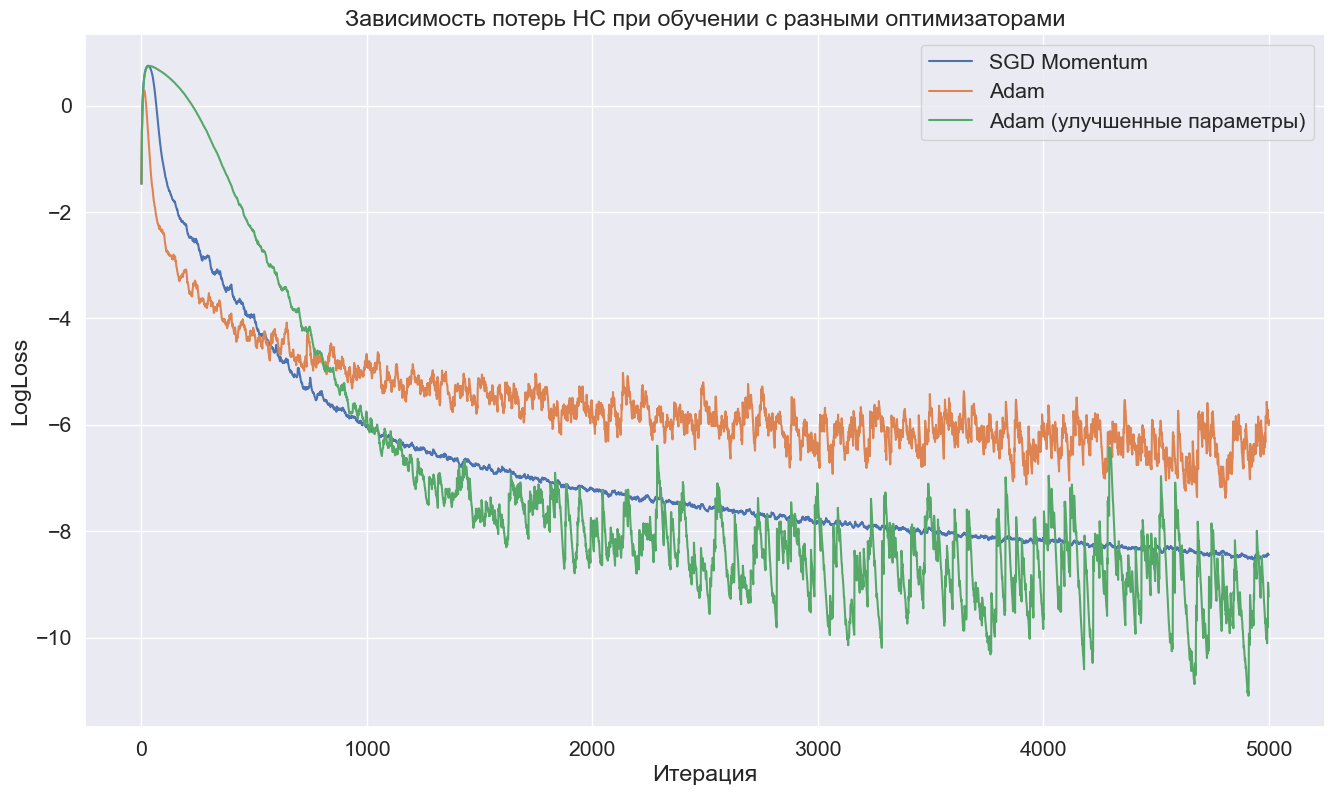

In [160]:
plt.figure(figsize=(16, 9))
plt.title("Зависимость потерь НС при обучении с разными оптимизаторами")
plt.ylabel("LogLoss")
plt.xlabel("Итерация")
plt.plot(preproc(loss_relu_sgd), label='SGD Momentum')
plt.plot(preproc(loss_relu_adam), label='Adam')
plt.plot(preproc(loss_relu_adam_2), label='Adam (улучшенные параметры)')
plt.legend()
plt.show()


__Комментарий:__ варьируя параметры, можно добиваться того, что на дальней дистанции Adam начинает вести себя лучше и еще менее стабильнее, но хуже и стабильнее на короткой. Тем не менее, а нужно ли так долго обучать сеть в нашем случае на самом деле? Давайте посмотрим, как ведут себя во время обучения лосс и точность не на тренировочном наборе, а на валидационном.

In [161]:
def validation_training(trained_net,
                  name: str,
                  n_epoch=100,
                  batch_size=1000,
                  criterion=ClassNLLCriterion(),
                  optimizer=sgd_momentum,
                  optimizer_config={'learning_rate': 5e-2, 'momentum': 0.9},
                  optimizer_state={}):

    net = trained_net
    net.train()
    val_loss_history = []
    val_accuracy_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer(net.getParameters(),
                      net.getGradParameters(),
                      optimizer_config,
                      optimizer_state)

        val_predictions = net.forward(X_val)
        val_loss = criterion.forward(val_predictions, y_val)
        val_loss_history.append(val_loss)

        val_acc = validate_network(net)
        val_accuracy_history.append(val_acc)

        print(f'#{i + 1}/{n_epoch} epoch loss: {round(val_loss, 7)}, acc: {val_acc}', end='\r')

    net.evaluate()
    return val_loss_history, val_accuracy_history


In [164]:
val_loss_sgd, val_accuracy_sgd = validation_training(net_relu_opt, "net_relu_sgd")

In [165]:

val_loss_adam, val_accuracy_adam = validation_training(net_relu_opt, "net_relu_adam", optimizer=adam_optimizer,
                                                       optimizer_config=optimizer_config_adam, optimizer_state=optimizer_state_adam)

In [166]:
val_loss_adam2, val_accuracy_adam2 = validation_training(net_relu_opt, "net_relu_adam_2", optimizer=adam_optimizer,
                                                         optimizer_config=optimizer_config_adam_2, optimizer_state=optimizer_state_adam_2)


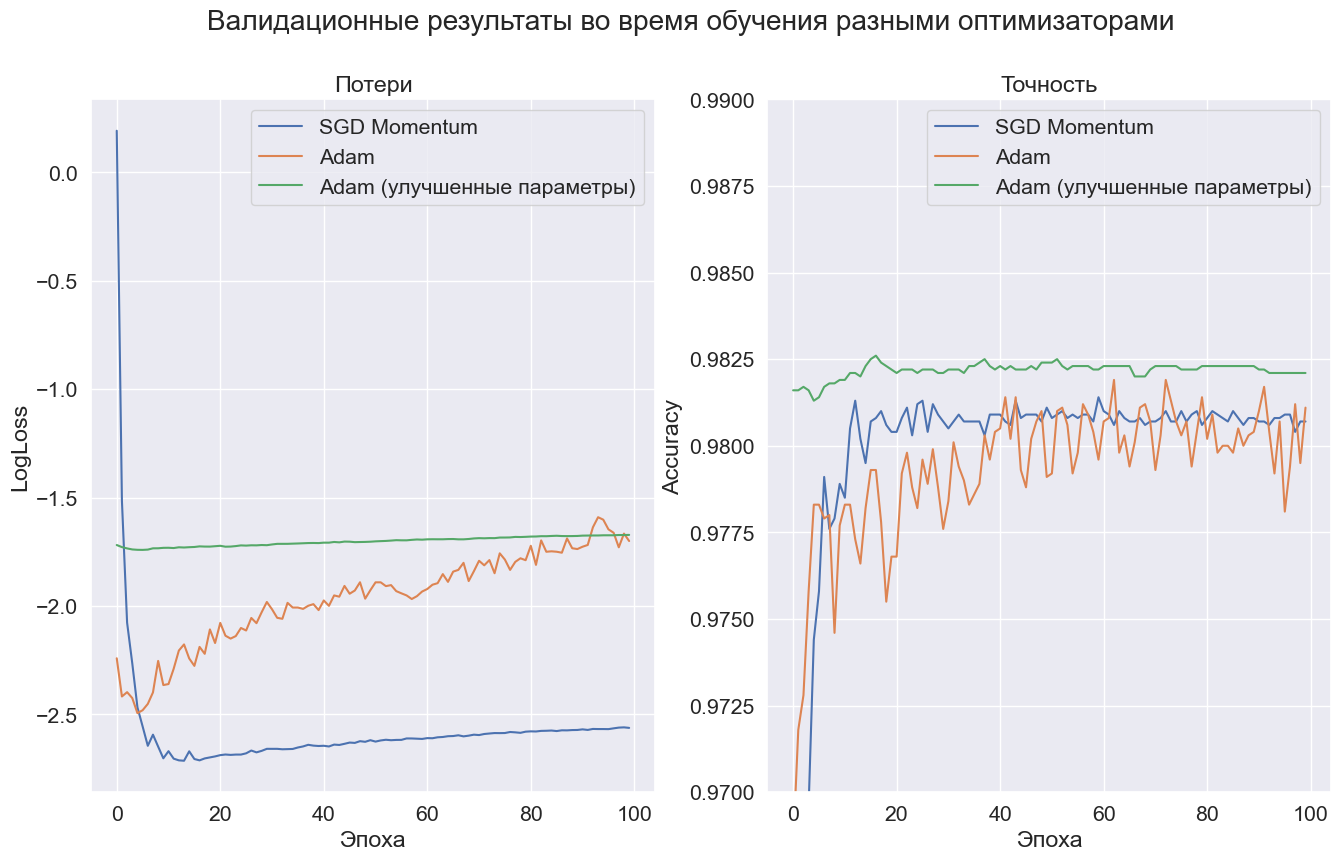

In [256]:
fig = plt.figure(figsize=(16, 9))
ax1, ax2 = fig.subplots(1, 2)
fig.suptitle("Валидационные результаты во время обучения разными оптимизаторами")

ax1.set_title("Потери")
ax1.set_ylabel("LogLoss")
ax1.set_xlabel("Эпоха")
ax1.plot(preproc(val_loss_sgd, alpha=0), label='SGD Momentum')
ax1.plot(preproc(val_loss_adam, alpha=0), label='Adam')
ax1.plot(preproc(val_loss_adam2, alpha=0), label='Adam (улучшенные параметры)')
ax1.legend()

ax2.set_title("Точность")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Эпоха")
ax2.plot(val_accuracy_sgd, label='SGD Momentum')
ax2.plot(val_accuracy_adam, label='Adam')
ax2.plot(val_accuracy_adam2, label='Adam (улучшенные параметры)')
ax2.set_ylim([0.97, 0.99])
ax2.legend()
plt.show()

__Комментарий:__ интересно, что на валидационной выборке лосс почти сразу падает и начинает расти. У "улучшенного" адама он самый высокий, но при этом и точность самая высокая и стабильная, а точность, пожалуй, будет поважнее лосса. Формально можно говорить о том, что примерно после 10-20 эпох начинается переобучение, хотя на точности это практически не сказывается. Поэтому больше двадцати эпох смотреть, на самом деле, смысла нет.

Отметим, что 20 эпох --- это 1000 итераций, и за эти 1000 итераций в первых экспериментах ReLU и LReLU уже успевали сильно вырваться вперед, поэтому вывод о том, что они представляют собой самые подходящие функции, остается в силе.

Сказать, какой оптимизатор лучше --- Adam или SGD momentum ---, однозначно не получается. Я выберу SGD с импульсом, тк он чуть-чуть быстрее, заметно лучше в плане оптимизации лосса на валидации, стабильнее, не сильно хуже в плане оптимизации лосса на обучении и совершенно незначительно хуже по точности.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

__Комментарий:__ использовать расширение данных таким образом в этой задаче, пожалуй, не очень актуально, потому что большинство цифр чувствительны к своему расположению (если перевернуть 6, то получится 9, если чуть чуть повернуть 7, можно ее перепутать с единичкой, если отразить 5, можно ее перепутать с 2кой и тд). Зато можно чуть чуть пошуметь. Так как мы решили, что будем обучать всего за 20 эпох с помощью SGD, а при этом лосс на тренировочном наборе продолжает падать и падать достаточно стабильно, использовать rate decay нет смысла --- мы не "прыгаем" около нуля, поэтому уменьшать rate смысла особенно нет.

Digits example:


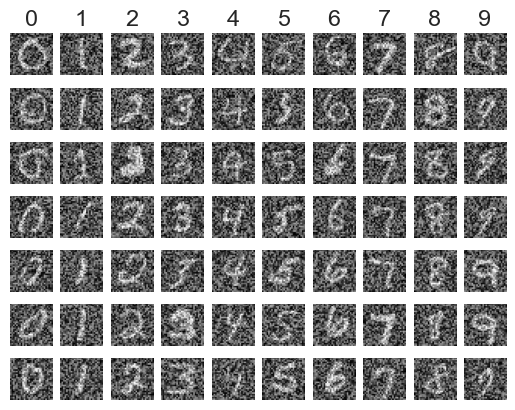

In [181]:
def add_noise(batch, old_weight = 96, new_weight = 160):
    total = old_weight + new_weight
    shape = batch.shape
    noise = np.random.uniform(size=shape[0]*shape[1])
    noise = noise.reshape(shape)
    return batch * (old_weight / total) + noise * (new_weight / total)


# Скопировал из начала :)
for x_batch, y_batch in get_batches((X_train, y_train_unenc), 1000):
    x_batch = add_noise(x_batch)
    print("Digits example:")
    classes = list(np.arange(10))
    num_classes = len(classes)
    samples_per_class = 7
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_batch == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow((256 * x_batch[idx]).reshape((28, 28)).astype('uint8'), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    break


Но прежде выберем параметр p для дропаута.

In [273]:
def test_dropout(p, second_layer):
    total_acc = 0.0
    total_iters = 10
    
    net_dropout = Sequential()
    net_dropout.add(Linear(784, 256))
    net_dropout.add(BatchNormalization(alpha=0.85))
    net_dropout.add(ChannelwiseScaling(n_out=256))
    net_dropout.add(ReLU())
    if p > 0:
        net_dropout.add(Dropout(p=p))

    net_dropout.add(Linear(256, 100))
    net_dropout.add(BatchNormalization(alpha=0.85))
    net_dropout.add(ChannelwiseScaling(n_out=100))
    net_dropout.add(ReLU())
    if second_layer and p > 0:
        net_dropout.add(Dropout(p=p))

    net_dropout.add(Linear(100, 10))
    net_dropout.add(LogSoftMax())

    return validation_training(net_dropout, f"net_dropout_{p}_{second_layer}", 20)

loss_single = []
loss_double = []
acc_single = []
acc_double = []
for i in range(10):
    p = i / 10
    print(f"\np={p}, single")
    loss, acc = test_dropout(p, False)
    loss_single.append(loss)
    acc_single.append(acc)

    print(f"\np={p}, double")
    loss, acc = test_dropout(p, True)
    loss_double.append(loss)
    acc_double.append(acc)



p=0.0, single
#20/20 epoch loss: 0.0782491, acc: 0.9773
p=0.0, double
#20/20 epoch loss: 0.0729654, acc: 0.9802
p=0.1, single
#20/20 epoch loss: 0.0825725, acc: 0.9784
p=0.1, double
#20/20 epoch loss: 0.0926342, acc: 0.9748
p=0.2, single
#20/20 epoch loss: 0.0794155, acc: 0.9787
p=0.2, double
#20/20 epoch loss: 0.0968328, acc: 0.9726
p=0.3, single
#20/20 epoch loss: 0.0915386, acc: 0.9734
p=0.3, double
#20/20 epoch loss: 0.1115578, acc: 0.9677
p=0.4, single
#20/20 epoch loss: 0.09856, acc: 0.972214
p=0.4, double
#20/20 epoch loss: 0.1349179, acc: 0.9632
p=0.5, single
#20/20 epoch loss: 0.1119427, acc: 0.9689
p=0.5, double
#20/20 epoch loss: 0.1668455, acc: 0.9583
p=0.6, single
#20/20 epoch loss: 0.1350409, acc: 0.9615
p=0.6, double
#20/20 epoch loss: 0.2083366, acc: 0.9444
p=0.7, single
#20/20 epoch loss: 0.1688597, acc: 0.9529
p=0.7, double
#20/20 epoch loss: 0.2885119, acc: 0.9281
p=0.8, single
#20/20 epoch loss: 0.228696, acc: 0.93249
p=0.8, double
#20/20 epoch loss: 0.4801215, acc

__Комментарий:__ видно без графиков, что при больших p все становится значительно хуже и мы "перерегуляризовываем" задачу, поэтому посмотрим только на маленькие p.

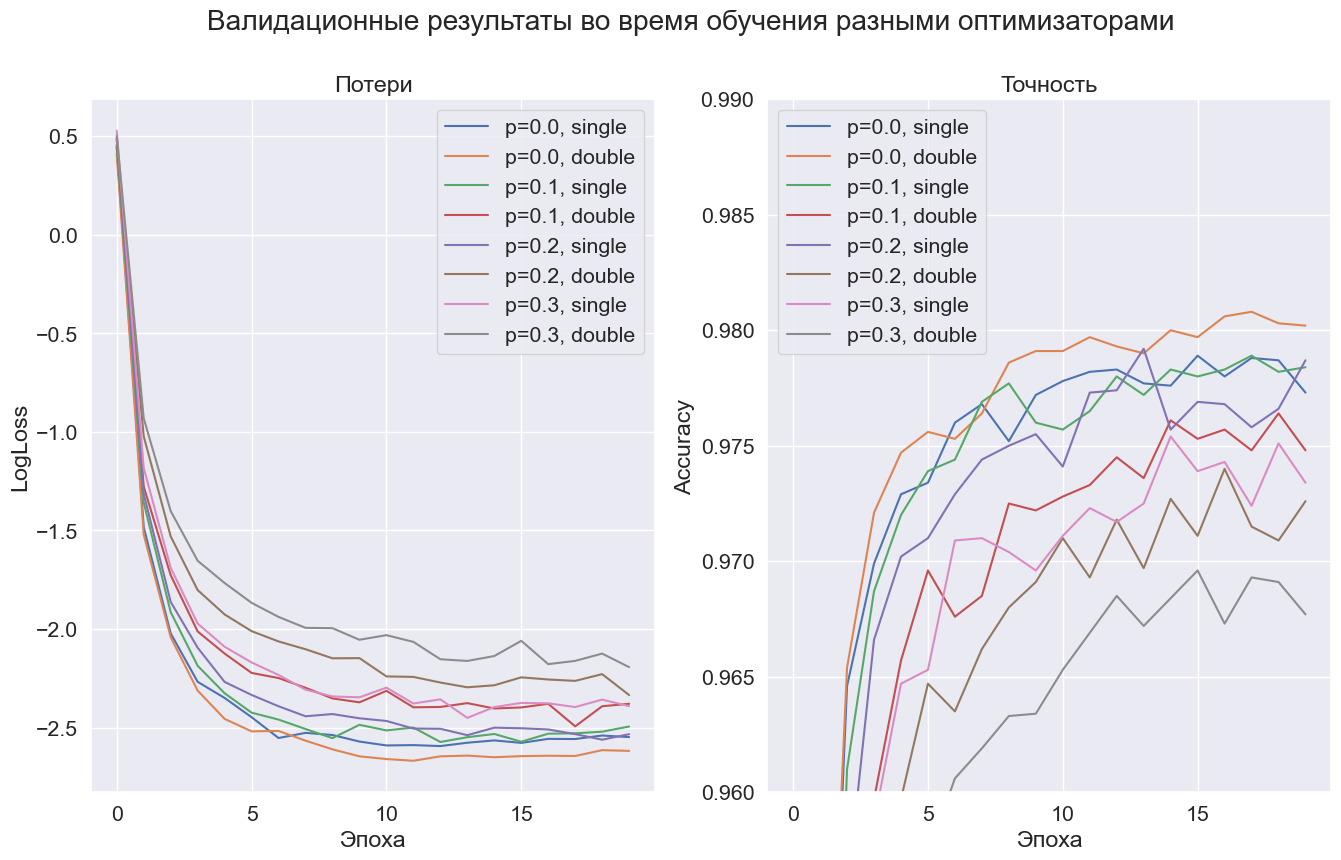

In [276]:
fig = plt.figure(figsize=(16, 9))
ax1, ax2 = fig.subplots(1, 2)
fig.suptitle("Валидационные результаты во время обучения разными оптимизаторами")

ax1.set_title("Потери")
ax1.set_ylabel("LogLoss")
ax1.set_xlabel("Эпоха")
for i in range(4):
    p = i / 10
    ax1.plot(preproc(loss_single[i], alpha=0), label=f"p={p}, single")
    ax1.plot(preproc(loss_double[i], alpha=0), label=f"p={p}, double")

ax1.legend()

ax2.set_title("Точность")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Эпоха")
for i in range(4):
    p = i / 10
    ax2.plot(acc_single[i], label=f"p={p}, single")
    ax2.plot(acc_double[i], label=f"p={p}, double")
ax2.set_ylim([0.96, 0.99])
ax2.legend()
plt.show()


__Комментарий:__ приходится прийти к заключению, что без дропаута работает лучше, чем с дропаутом, особенно двойным :) Тем не менее, чтобы оставить хоть какую-нибудь регуляризацию кроме нормировки, вставим дропаут с p=0.1 после первого слоя: он отработал так же хорошо, как и один из двух запусков без дропаута.

In [280]:
net_best = Sequential()
net_best.add(Linear(784, 256))
net_best.add(BatchNormalization(alpha=0.85))
net_best.add(ChannelwiseScaling(n_out=256))
net_best.add(ReLU())
net_best.add(Dropout(p=0.1))
net_best.add(Linear(256, 100))
net_best.add(BatchNormalization(alpha=0.85))
net_best.add(ChannelwiseScaling(n_out=100))
net_best.add(ReLU())
net_best.add(Linear(100, 10))
net_best.add(LogSoftMax())


def validate_network_test(net):
    ans = net.forward(X_test)
    return np.sum(np.argmax(ans, axis=1) == y_test) / len(X_test)

loss_history = []
acc_history = []

start = time()
noise_level = 0

n_epoch_best = 20

for i in range(n_epoch_best):
    noise_level += 3
    batch_idx = 0
    net_best.train()
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

        net_best.zeroGradParameters()
        # if batch_idx % 2 == 0:
        #     x_batch = add_noise(x_batch, 256 - noise_level, noise_level)

        # Forward
        predictions = net_best.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net_best.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net_best.getParameters(),
                     net_best.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)
        batch_idx += 1

    net_best.evaluate()
    acc = validate_network(net_best)
    acc_history.append(acc)
    print(f'#{i + 1}/{n_epoch_best} epoch loss: {round(loss, 7)}, acc: {acc}', end='\r')

print(f"\nTime elapsed: {time() - start}")

#20/20 epoch loss: 0.0374285, acc: 0.9815
Time elapsed: 67.8767659664154


Print here your accuracy on test set. It should be around 90%.

In [282]:
print(f"Dropout network final accuracy: {validate_network_test(net_best)}")
print(f"No dropout: {validate_network_test(net_relu_sgd)}")

Dropout network final accuracy: 0.9789
No dropout: 0.9805


__Комментарий:__ надо признать, что фокус с шумом не сработал в этой задаче: тестовая выборка не зашумлена, поэтому точность только снизилась (но если бы к нам пришли зашумленные данные, это явно был бы полезный прием).

Точность получилась по сути такой же, разница на 16 распознанных изображений при датасете размером 10000 не имеет значения. В любом случае, точность 97.9 - 98.1% --- это весьма высокая точность.

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [283]:
import torch
import torch.nn as nn

torch_digit_nn = nn.Sequential(
    nn.Linear(784, 256),
    nn.BatchNorm1d(256, 1e-3, momentum=0.85),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(256, 100),
    nn.BatchNorm1d(100, 1e-3, momentum=0.85),
    nn.ReLU(),
    nn.Linear(100, num_classes),
    nn.LogSoftmax()
)

torch_optimizer = torch.optim.SGD(torch_digit_nn.parameters(), 
                                  lr=1e-1, momentum=0.9)

torch_criterion = nn.NLLLoss()

In [284]:
torch_loss_history = []
torch_acc_history = []

X_test_torch = torch.tensor(X_test)
start = time()
for i in range(n_epoch_best):
    torch_digit_nn.train(True)
    for x_batch, y_batch in get_batches((X_train, y_train_unenc), batch_size):
        torch_optimizer.zero_grad()
        predictions = torch_digit_nn.forward(torch.tensor(x_batch))
        loss = torch_criterion(predictions, torch.tensor(y_batch))

        loss.backward()
        torch_optimizer.step()

        torch_loss_history.append(loss.item())
    # Теперь у нас есть батчнорм и надо для валидации
    # каждый раз это делать
    torch_digit_nn.train(False)
    
    with torch.no_grad():
        test_pred = torch_digit_nn.forward(X_test_torch)
        acc = np.sum(np.argmax(test_pred.cpu().numpy(), axis=1) == y_test) / len(X_test)
        print(f'#{i + 1}/{n_epoch_best} epoch loss: {round(loss.item(), 7)}, acc: {acc}', end='\r')
        torch_acc_history.append(acc)

print(f"\nTime elapsed: {time() - start}")

C:\Users\JulesIMF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


#20/20 epoch loss: 0.0387185, acc: 0.9805
Time elapsed: 8.636144876480103


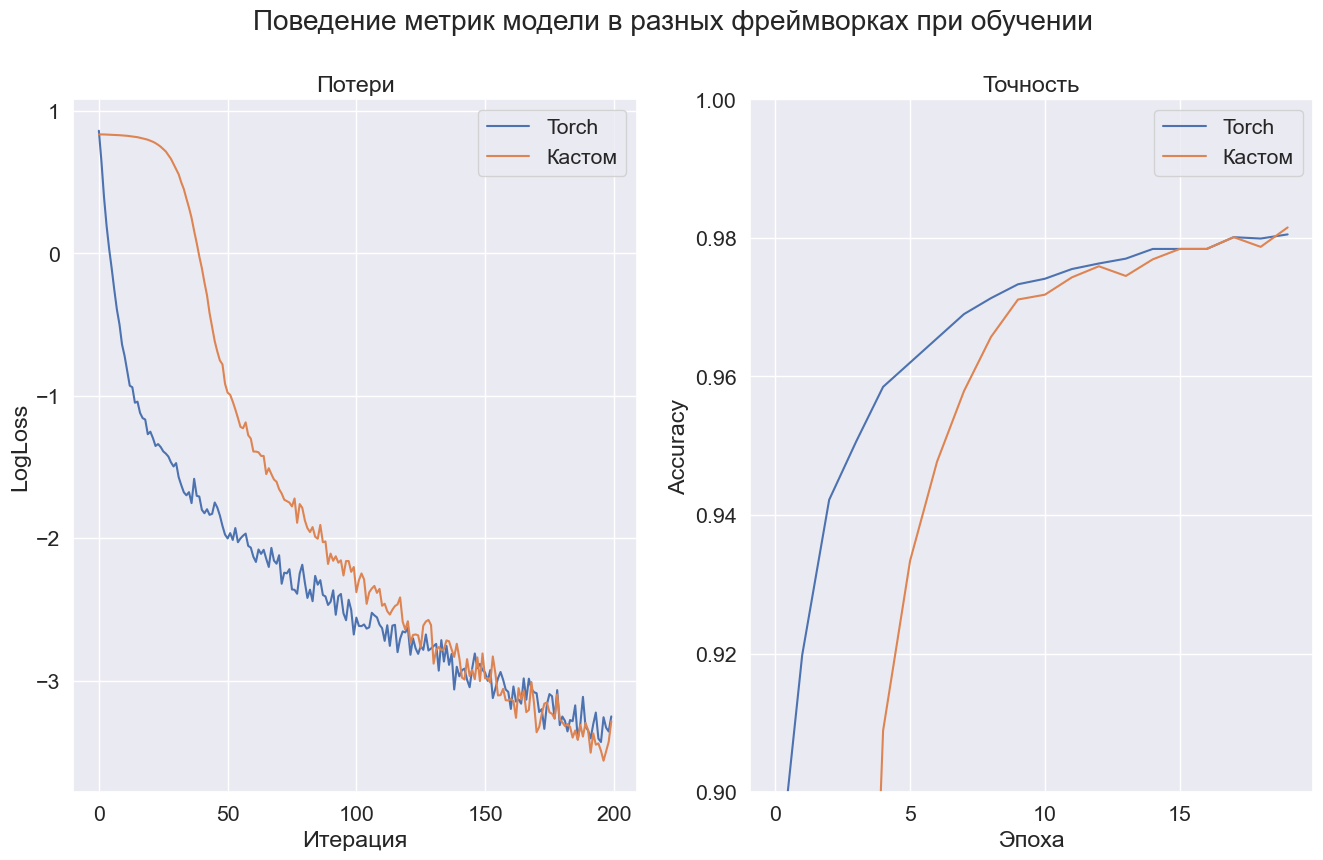

In [286]:
fig = plt.figure(figsize=(16, 9))
ax1, ax2 = fig.subplots(1, 2)
fig.suptitle("Поведение метрик модели в разных фреймворках при обучении")

ax1.set_title("Потери")
ax1.set_ylabel("LogLoss")
ax1.set_xlabel("Итерация")
ax1.plot(preproc(torch_loss_history, alpha=0.0), label="Torch")
ax1.plot(preproc(loss_history, alpha=0.0), label = "Кастом")
ax1.legend()

ax2.set_title("Точность")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Эпоха")
ax2.plot(torch_acc_history, label="Torch")
ax2.plot(acc_history, label="Кастом")
ax2.set_ylim([0.9, 1.0])
ax2.legend()
plt.show()


__Вывод:__ на такой же модели мы в итоге получили очень близкие точность и потери и видно, что наша кастомная реализация ведет себя в целом похоже на промышленную, но промышленная сходится заметно быстрее и по итерациям, и особенно по времени работы (в 8 раз меньше времени затрачено).